Plot with the new Lyman alpha fits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '../new_lya/'
lyas = glob.glob('{}*results.csv'.format(path))
lyas

['../new_lya/GJ649_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ674_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ15A_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ729_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ849_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ1132_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/LHS2686_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ676A_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ163_LyA_only_CowanSR_MCMC_results.csv']

../new_lya/GJ649_LyA_only_CowanSR_MCMC_results.csv
../new_lya/GJ674_LyA_only_CowanSR_MCMC_results.csv
../new_lya/GJ15A_LyA_only_CowanSR_MCMC_results.csv
../new_lya/GJ729_LyA_only_CowanSR_MCMC_results.csv
../new_lya/GJ849_LyA_only_CowanSR_MCMC_results.csv
../new_lya/GJ1132_LyA_only_CowanSR_MCMC_results.csv
../new_lya/LHS2686_LyA_only_CowanSR_MCMC_results.csv
../new_lya/GJ676A_LyA_only_CowanSR_MCMC_results.csv
../new_lya/GJ163_LyA_only_CowanSR_MCMC_results.csv


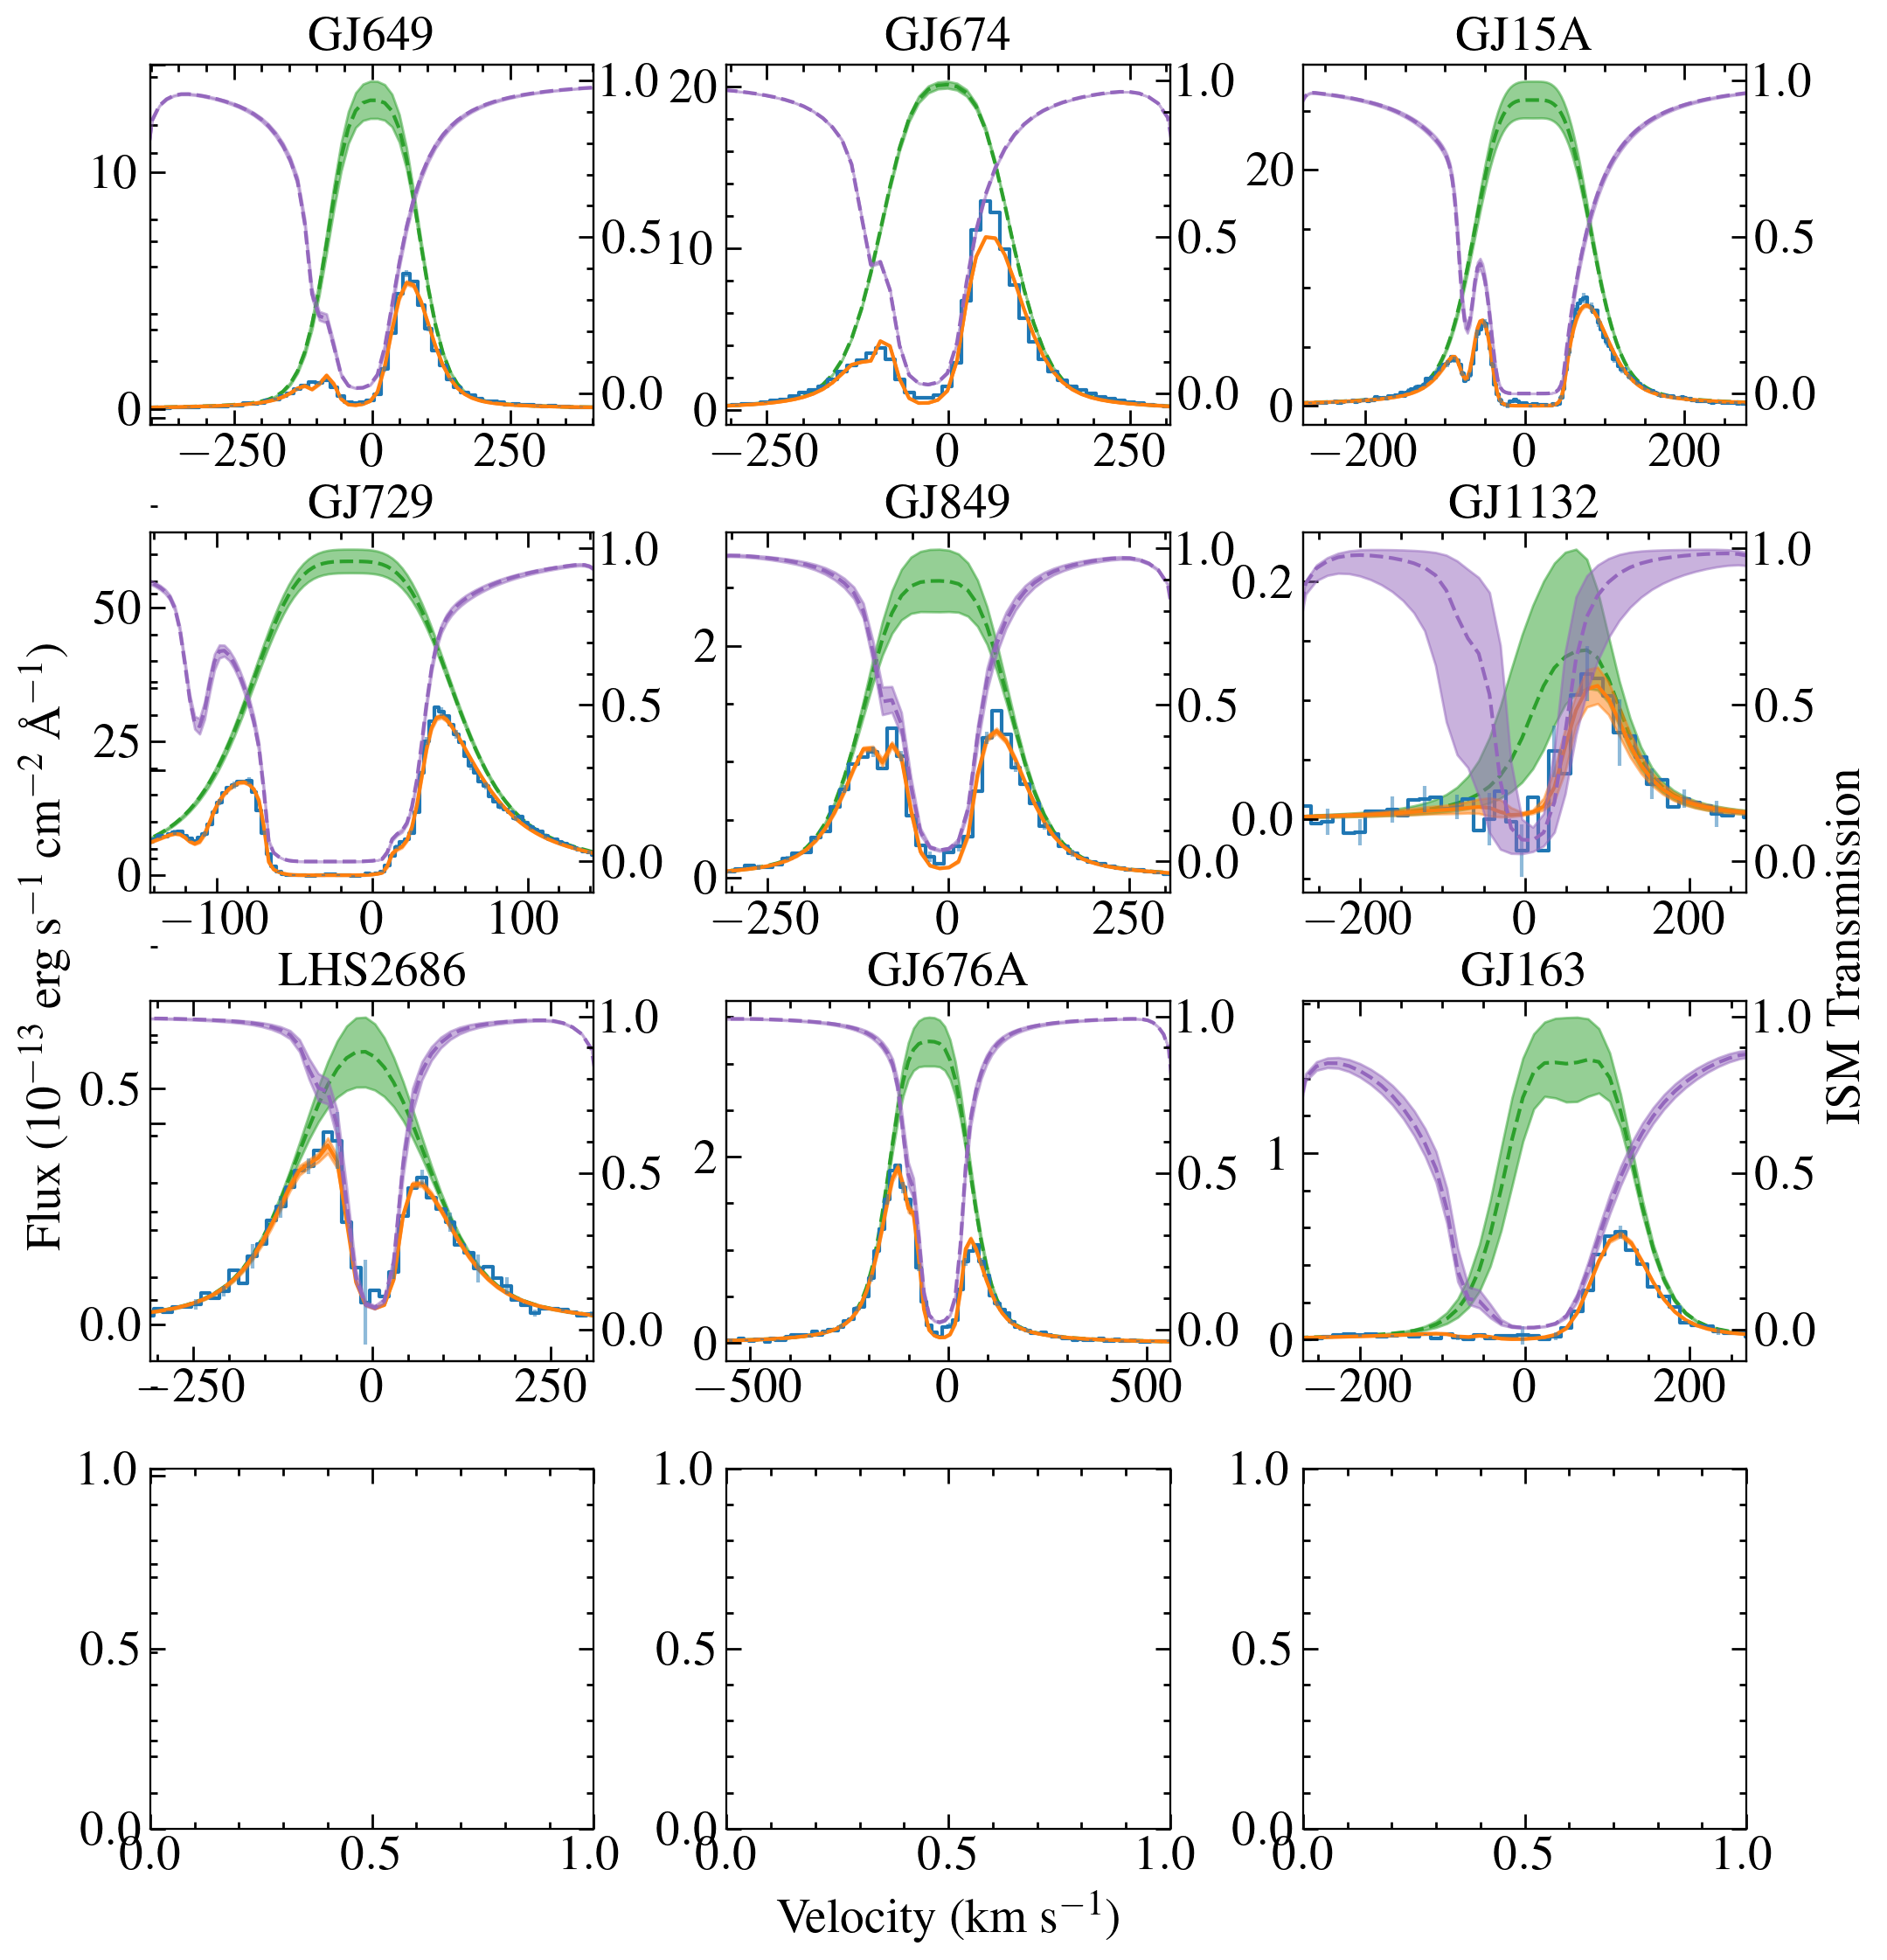

In [59]:
fig, axes = plt.subplots(figsize=(12, 12), nrows=4, ncols=3)
lya = 1215.67
ism_scale = 2.3e-13 #scaling ism to plot
fscale = 1e13 #scaling flux to axis
ism_scale *= fscale
for i in range(len(lyas)):
    spec = lyas[i]
    print(spec)
    data = Table.read(spec)
    ax = axes.flat[i]
    # print(data['h1_b value'][2])
    v = (data['wave_lya']*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
    ax.step(v, data['flux_lya']*fscale, c='C0', label = 'Observed Spectrum', zorder=0, where='mid')
    ax.errorbar(v, data['flux_lya']*fscale, yerr=data['error_lya']*fscale, alpha=0.5, errorevery=3, ls='none', c='C0')
    ax.plot(v, data['lya_model_median']*fscale, c='C1', label='Model fit', zorder=1)
    ax.fill_between(v.value, data['lya_model_high_1sig']*fscale,data['lya_model_low_1sig']*fscale, color='C1', alpha=0.5)
    
    ax.plot(v, data['lya_intrinsic_median']*fscale, c='C2', ls='--', label=r'Intrinsic Ly$\alpha$ profile', zorder=-1)
    ax.fill_between(v.value, data['lya_intrinsic_high_1sig']*fscale,data['lya_intrinsic_low_1sig']*fscale, color='C2', alpha=0.5, zorder=-10)
    
    name = os.path.split(spec)[1][:-34]
    ax.set_title(name, size=20)
    
#     plt.plot(v, data['lya_ism_median']*ism_scale, c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
#     plt.fill_between(v.value, data['lya_ism_high_1sig']*ism_scale,data['lya_ism_low_1sig']*ism_scale, color='C4', alpha=0.5, zorder=-10)
    
    xlim = min([abs(min(v.value)), max(v.value)])-10
    ax.set_xlim(-xlim, xlim)
    # # plt.ylim(0.01, 2.49)
    # if i > 0:
    #     # plt.yticks(visible=False)
    #     ax[i].set_yticklabels([])
    # if i == 0:
    #     # plt.legend(loc=2, frameon=True)
    #     plt.ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)
    # plt.xticks(visible=False)
    
    ax2=ax.twinx()
    ax2.plot(v, data['lya_ism_median'], c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
    ax2.fill_between(v.value, data['lya_ism_high_1sig'],data['lya_ism_low_1sig'], color='C4', alpha=0.5, zorder=-10)
    ax2.set_ylim(-0.1, 1.05)

    
    # ax2.annotate('Phase = {}'.format(phase_sort[i]), (0.95, 0.95), xycoords = 'axes fraction', ha='right', va='top', bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
    
#     if i < 3:
#         ax2.set_yticklabels([])
#     if i == 3:
#         ax2.set_ylabel('ISM Transmission')
#     ax2.set_ylim(-0.01, 1.05)
ax1 = fig.add_subplot(111, frame_on=False)
ax1.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
# plt.ylabel('Flux ($10^{-14}$\,erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20, labelpad=12)
ax1.set_xlabel('Velocity (km s$^{-1}$)', size=20)
ax1.set_ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)

ax3 = ax1.twinx()
ax3.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')

# ax3.axis('off')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_ylabel('ISM Transmission')

plt.tight_layout()
fig.subplots_adjust(wspace=0.3, hspace=0.3)


In [ ]:
data = Table.read(spec)

In [ ]:
data

In [ ]:
fig, ax= plt.subplots(ncols=2)
for i in range(len(ax)):
    print(i)
    ax[i].plot([1, 2], [1,2])

../new_lya/GJ1132_LyA_only_CowanSR_MCMC_results.csv


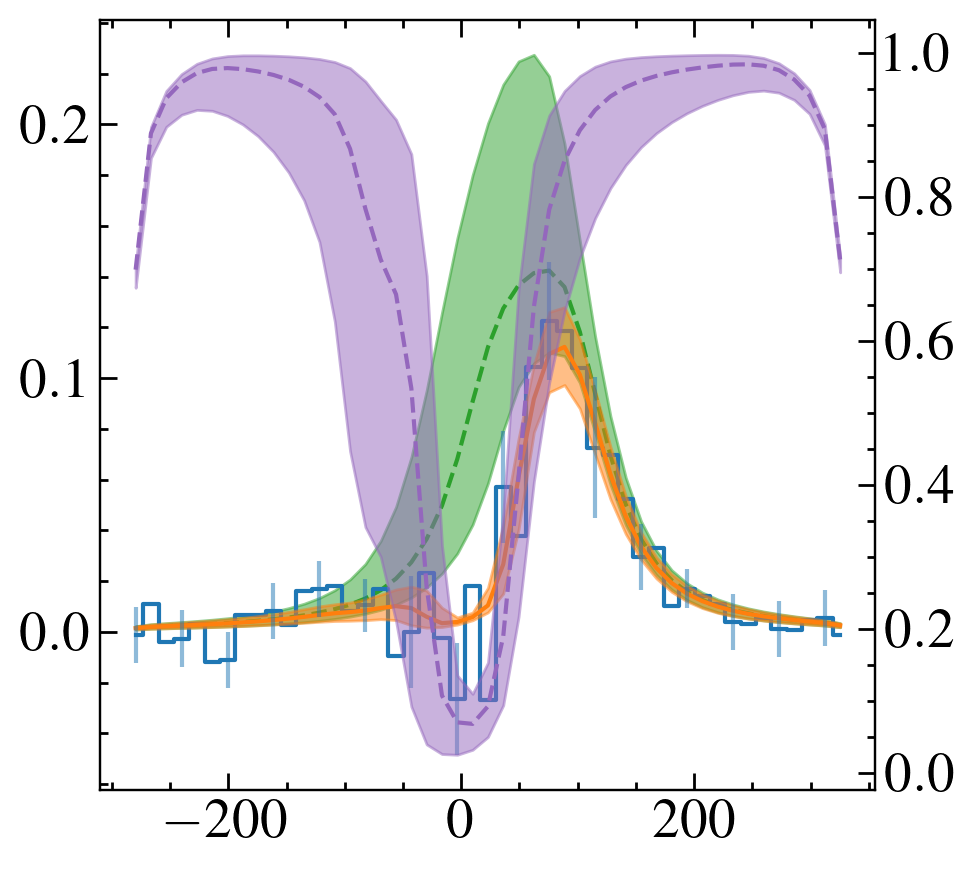

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
lya = 1215.67
ism_scale = 2.3e-13 #scaling ism to plot
fscale = 1e13 #scaling flux to axis
ism_scale *= fscale
# for i in range(len(lyas)):
spec = lyas[5]
print(spec)
data = Table.read(spec)
# print(data['h1_b value'][2])
v = (data['wave_lya']*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
ax.step(v, data['flux_lya']*fscale, c='C0', label = 'Observed Spectrum', zorder=0, where='mid')
ax.errorbar(v, data['flux_lya']*fscale, yerr=data['error_lya']*fscale, alpha=0.5, errorevery=3, ls='none', c='C0')
ax.plot(v, data['lya_model_median']*fscale, c='C1', label='Model fit', zorder=1)
ax.fill_between(v.value, data['lya_model_high_1sig']*fscale,data['lya_model_low_1sig']*fscale, color='C1', alpha=0.5)

ax.plot(v, data['lya_intrinsic_median']*fscale, c='C2', ls='--', label=r'Intrinsic Ly$\alpha$ profile', zorder=-1)
ax.fill_between(v.value, data['lya_intrinsic_high_1sig']*fscale,data['lya_intrinsic_low_1sig']*fscale, color='C2', alpha=0.5, zorder=-10)

#     plt.plot(v, data['lya_ism_median']*ism_scale, c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
#     plt.fill_between(v.value, data['lya_ism_high_1sig']*ism_scale,data['lya_ism_low_1sig']*ism_scale, color='C4', alpha=0.5, zorder=-10)

# plt.xlim(-499, 499)
# # plt.ylim(0.01, 2.49)
# if i > 0:
#     # plt.yticks(visible=False)
#     ax[i].set_yticklabels([])
# if i == 0:
#     # plt.legend(loc=2, frameon=True)
#     plt.ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)
# plt.xticks(visible=False)

ax2=ax.twinx()
ax2.plot(v, data['lya_ism_median'], c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
ax2.fill_between(v.value, data['lya_ism_high_1sig'],data['lya_ism_low_1sig'], color='C4', alpha=0.5, zorder=-10)

# ax2.annotate('Phase = {}'.format(phase_sort[i]), (0.95, 0.95), xycoords = 'axes fraction', ha='right', va='top', bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))

#     if i < 3:
#         ax2.set_yticklabels([])
#     if i == 3:
#         ax2.set_ylabel('ISM Transmission')
#     ax2.set_ylim(-0.01, 1.05)
# ax.set_xlabel('Velocity (km\,s${-1}$)')
# ax.set_ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')